# Final Project of Quantum Computation

20195048 김현성

## Problem 1

Solve the following linear system with HHL algorithm

$$\begin{bmatrix}1 & -1/3 \\ -1/3 & 1\end{bmatrix} \mathbf{x} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$$

## Problem 2 

Extend the problem 1 result and solve following equation

$$\frac{1}{4}
\begin{bmatrix}
15 & 9 & 5 & -3 \\
9 & 15 & 3 & -5 \\
5 & 3 & 15 & -9 \\
-3 & -5 & -9 & 15\end{bmatrix} \mathbf{x} = 
\frac{1}{2} 
\begin{bmatrix}
1\\
1\\
1\\
1
\end{bmatrix}$$

## Answer

Since the matrix already a Hermit matrix, the calculation does not require a conversion. Before we implement HHL. Let us see the exact solutions of the each system.

### Exact solutions

In [1]:
from IPython.display import display, Math

In [2]:
import sympy as sp
from sympy.printing.mathml import mathml
sp.init_printing(use_unicode=True) # allow LaTeX printing


In [3]:
scale1 = 3
A1 = sp.Matrix([[3, -1], [-1, 3]])/scale1
b1 = sp.Matrix([[0], [1]])
scale2 = 4
A2 = sp.Matrix(
    [
        [15, 9, 5, -3], 
        [9, 15, 3, -5],
        [5, 3, 15, -9],
        [-3, -5, -9, 15]])/scale2
b2 = sp.Matrix(4*[[2]])/scale2

A1_np = np.array(A1).astype(complex)
A2_np = np.array(A2).astype(complex)

In [4]:
display(Math(sp.latex(A1)))
display(Math(f"$det(A_1): {A1.det()}$",))
display(Math("$\mathbf{x}: " + sp.latex(A1.solve(b1).T)))
display(Math(sp.latex(A2)))
display(Math(f"$det(A_2): {A2.det()}$",))
display(Math("$\mathbf{x}: " + sp.latex(A2.solve(b2).T)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [86]:
A2.eigenvals()

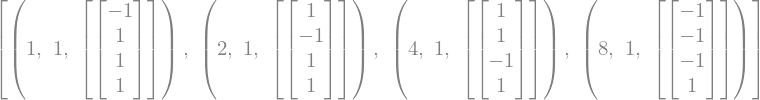

In [88]:
A2.eigenvects()

## System configuration

Eigenvalues and eigenvectos of each systems

* $\{\lambda _i\}_{A_1} = \{ \frac{2}{3}, \frac{4}{3}\}$
* $\{\lambda _i\}_{A_2} = \{ \frac{1}{4}, \frac{2}{4}, \frac{4}{4}, \frac{8}{4}\}$

then, the desired scaled eigenvalues and the scale factors are 

$$\tilde{\lambda} = N \frac{\lambda }{2 \pi} t $$

* $\{\tilde{\lambda}_i\}_{A_1} = \{ 1, 2\}$
* $\{\tilde{\lambda}_i\}_{A_2} = \{ 1, 2, 4, 8\}$
* $t_1 = \frac{3}{4} \pi $
* $t_2 = \frac{1}{2} \pi $


### Implementation of HHL algorithm

Major steps of HHL algorithm

3 registers required: ancilla, main-register, b-register.

1. State preparation: Encoding $|b\rangle$ vector to the register, amplitude encoding(b).
2. Quantum Phase estimation(main, b).
3. Ancilla bit rotation(main, ancilla).
4. Inverse Quantum Phase estimation(main, b).
5. Measurement.

### Decomposition of Pauli matrix 

In the HHL algorithm there is a evolution circuit $U = \exp(i H t)$ gate of the given $A$ matrix.
Unfortunately, to implment on the gate, we have to encode the given hamiltonian as summation of 
unitary and hermit matrices. That means we needs a Pauli-polynomial of the given matrix.

In [5]:
import numpy as np
from itertools import combinations, combinations_with_replacement as re_combi, product
from functools import reduce

I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = complex(0, 1)*np.array([[0, -1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

In [80]:
def krons(oper_list): # Operator Kronecker delta
    return reduce(np.kron, oper_list)
def get_pauli_xz_family_n_qubit(n, fam="Z"):
    G = Z if fam=="Z" else X
    return list(map(krons, product([I, G], repeat=int(n)))), list(map(lambda x: "".join(x), product(f"I{fam}", repeat=int(n))))
def get_pauli_familiy(n):
    p_xs, p_xs_str = get_pauli_xz_family_n_qubit(n, fam="X")
    p_zs, p_zs_str = get_pauli_xz_family_n_qubit(n, fam="Z")

    p_g = []
    p_g_str =[]
    for x_i, x_str in zip(p_xs, p_xs_str):
        for z_j, z_str in zip(p_zs, p_zs_str):
            g = x_i@z_j
    
            g_coef, g_str = get_coef(x_str, z_str)
    
            p_g.append(g_coef*g)
            p_g_str.append(g_str)
    return p_g, p_g_str    
def get_coef(x_str, z_str):
    n = len(x_str)
    x_str = x_str.replace("X", "1")
    x_str = x_str.replace("I", "0")
    z_str = z_str.replace("Z", "1")
    z_str = z_str.replace("I", "0")
    
    x_int = int(x_str, 2)
    z_int = int(z_str, 2)
    
    y_pos = format(x_int&z_int, f"0{n}b")
    z_pos = format((x_int|z_int) - x_int, f"0{n}b")
    x_pos = format((x_int|z_int) - z_int, f"0{n}b")

    g_str = []
    for x,y,z in zip(x_pos, y_pos, z_pos):
        if x==y and y==z:
            g_str.append("I")
        elif x== "1":
            g_str.append("X")
        elif y == "1":
            g_str.append("Y")
        else:
            g_str.append("Z")
    return complex(0,1)**y_pos.count("1"), "".join(g_str)
    
def frobenius_inner(A, B):
    n, n2 = A.shape
    return np.trace((A.conj().T)@B)/(n)

def get_pauli_coefficient(A):
    k, k2 = A.shape
    n = int(np.log2(k))
    p_fam, p_str = get_pauli_familiy(n)
    
    coef = {}
    for p_m, p_m_str in zip(p_fam, p_str):
        coef[p_m_str] = frobenius_inner(p_m, A)
    return coef

In [83]:
coef_A1 = get_pauli_coefficient(A1_np)
coef_A2 = get_pauli_coefficient(A2_np)

In [85]:
coef_A1

{'I': (1+0j), 'Z': 0j, 'X': (-0.3333333333333333+0j), 'Y': 0j}

In [84]:
coef_A2

{'II': (3.75+0j),
 'IZ': 0j,
 'ZI': 0j,
 'ZZ': 0j,
 'IX': 0j,
 'IY': 0j,
 'ZX': (2.25+0j),
 'ZY': 0j,
 'XI': 0j,
 'XZ': (1.25+0j),
 'YI': 0j,
 'YZ': 0j,
 'XX': 0j,
 'XY': 0j,
 'YX': 0j,
 'YY': (0.75+0j)}

The $A_1$ and $A_2$ become

$$A_1 = I - \frac{1}{3}X$$
$$A_2 = 3.75 II + 1.25 XZ + 2.25 ZX + 0.75 YY$$

About the commuting relationship, $A_1$ components are tirvially commuting each other.
For $A_2$ elements, we can use a method suggested by Chapuis et al (2018).

**Theorem**: For two pauli strings, there are X, Z family decomposition such as $P_1 = x_1 * z_1$ and $P_2 = x_2 * z_2$. 
The given Pauli strings are commuting if and only if $[x_1, z_2]$ and $[x_2, z_1]$ are either commute or anti-commute.

Now see below,

<center>

|Element|X-family|Z_family|
|:---:|:---:|:---:|
|XZ|XI|IZ|
|ZX|IX|ZI|
|YY|XX|ZZ|

</center>

All of them are anticommute, in cross line elements of X, Z family columns.
Therefore, we don't have to worry about the anticommute relationship on implementation.

---

In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [21]:
num_ancilla_register = 1
num_clock_register = 4
num_vector_register = 4 

In [22]:
qr_ancilla = QuantumRegister(num_ancilla_register, name="ancilla")
qr_clock = QuantumRegister(num_main_register, name="clock")
qr_vector = QuantumRegister(num_vector_register, name="vector")
cr = ClassicalRegister(1, name = "classic")

In [23]:
qc = QuantumCircuit(qr_ancilla, qr_main, qr_vector, cr, name="HHL")

State preparation for $|b\rangle$ vector.

In [24]:
from qiskit.circuit.library import StatePreparation

In [25]:
b1

In [ ]:
def initiate_matrix(A):
    #return A_gates
    pass
def HHL(A, wires):
    #return qc
    pass

### Results